# **Data Download using Colab**

In [1]:
# check if the GPU is the fastest one
!nvidia-smi

Sat Dec  7 19:26:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# install kaggle package
!pip install -q kaggle

In [4]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


## **Using Kaggle API to download data**

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!echo '{"username":"karentree","key":"ff57b9d030d708de9af1a8da9558d6df"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# download data using kaggle API
!kaggle datasets download -d karentree/artchallenge-118-artists-classification
# unzip the dat
!unzip /content/artchallenge-118-artists-classification.zip

# **Data Preparation**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.callbacks import *
from keras.initializers import *
from keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

Using TensorFlow backend.


In [8]:
# read in artists csv
artists = pd.read_csv("artists_all.csv")
artists = artists.iloc[:,1:]
artists.head()

,name,years,genre,nationality,paintings,number_of_genre
0,Amedeo Modigliani,1884 - 1920,['Expressionism'],['Italian'],193,1
1,Vasiliy Kandinskiy,1866 - 1944,"['Expressionism', 'Abstractionism']",['Russian'],88,2
2,Diego Rivera,1886 - 1957,"['Social Realism', 'Muralism']",['Mexican'],70,2
3,Claude Monet,1840 - 1926,['Impressionism'],['French'],73,1
4,Rene Magritte,1898 - 1967,"['Surrealism', 'Impressionism']",['Belgian'],194,2


In [9]:
artists[artists['paintings']<50].shape

(26, 6)

Only choose artists with more than 200 artworks because one fifth of artists with artworks less than 50.

In [0]:
# get artists with more than 200 pictures
artists = artists[artists['paintings'] > 200]
artists = artists.reset_index()
# get class weight
artists['class_weight'] = artists.paintings.sum() / (artists.shape[0] * artists.paintings)
class_weights = artists['class_weight'].to_dict()

In [0]:
# Explore images of top artists
images_dir = '/content/images'
artists_dirs = os.listdir(images_dir)
artists_name = artists['name'].str.replace(' ', '_').values
# change Albrecht_Dürer to Albrecht_DuтХа├кrer
artists_name = ['Albrecht_DuтХа├кrer' if x == 'Albrecht_Dürer' else x for x in artists_name]

In [12]:
# check if image directory is valid for all artists
for name in artists_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /content/images/Vincent_van_Gogh
Found --> /content/images/Pablo_Picasso
Found --> /content/images/Pierre-Auguste_Renoir
Found --> /content/images/Francisco_Goya
Found --> /content/images/Albrecht_DuтХа├кrer
Found --> /content/images/Alfred_Sisley
Found --> /content/images/Marc_Chagall
Found --> /content/images/Edgar_Degas
Found --> /content/images/Rembrandt
Found --> /content/images/Titian
Found --> /content/images/Paul_Gauguin
Found --> /content/images/Ivan_Shishkin
Found --> /content/images/Nicholas_Roerich
Found --> /content/images/Andrew_Wyeth
Found --> /content/images/Ivan_Aivazovsky
Found --> /content/images/Zinaida_Serebriakova
Found --> /content/images/Egon_Schiele
Found --> /content/images/Alphonse_Mucha
Found --> /content/images/Edward_Burne-Jones
Found --> /content/images/Gustave_Moreau
Found --> /content/images/Paul_Signac
Found --> /content/images/Alexandre_Benois
Found --> /content/images/Aleksandr_Deyneka
Found --> /content/images/Lucas_Cranach_the_Elder
Found

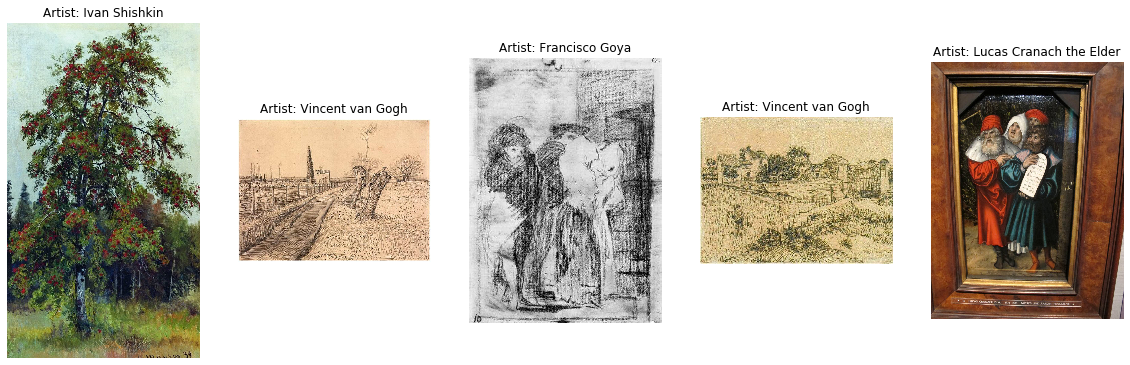

In [13]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_name)
    # get a random image in the image folder
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    #print(random_image)
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')
    
plt.show()

### **Data Augmentation**

In [14]:
# set the batch size
batch_size = 12
# set the input shape
train_input_shape = (224, 224, 3)
n_classes = artists.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )
train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical', # 118 class
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_name
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_name
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 7144 images belonging to 25 classes.
Found 1772 images belonging to 25 classes.
Total number of batches = 595 and 147


Show the results of data augmentation

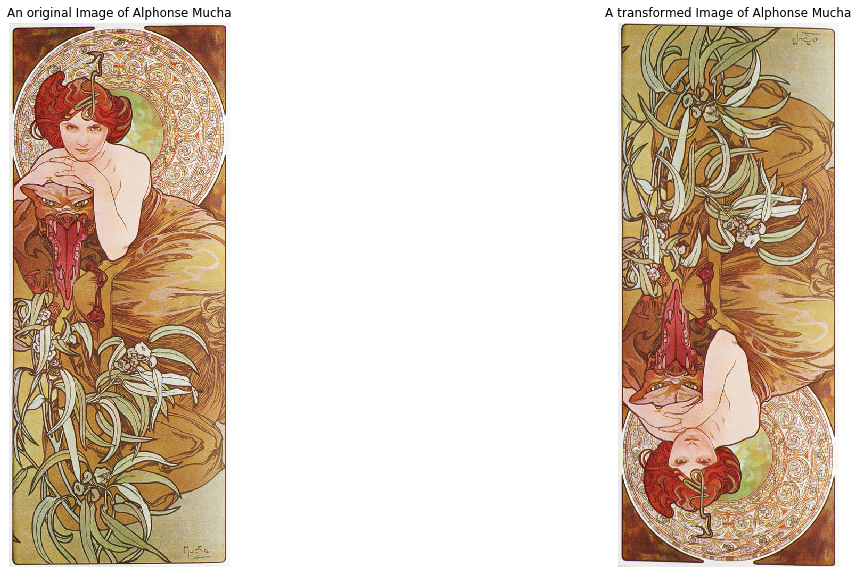

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()


# **Model Built**

Train the model and not using the transfer learning

In [16]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


Adding fully connected layers after the ResNet50 architecture. 
Put the batchnormalization after the Relu makes the input of next fully connected layer normalized.

In [17]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.7)(X)
X = Activation('relu')(X)
X = BatchNormalization()(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.7)(X)
X = Activation('relu')(X)
X = BatchNormalization()(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [18]:
# compile the model
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [0]:
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [21]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger("Resnet_history_artists_200_log.csv", append=True)

history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, csv_logger],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
595/595 [==============================] - 244s 410ms/step - loss: 2.3712 - acc: 0.3686 - val_loss: 1.9625 - val_acc: 0.5289
Epoch 2/30
595/595 [==============================] - 235s 395ms/step - loss: 1.7399 - acc: 0.5989 - val_loss: 1.6754 - val_acc: 0.6335
Epoch 3/30
595/595 [==============================] - 230s 387ms/step - loss: 1.5571 - acc: 0.6384 - val_loss: 1.7545 - val_acc: 0.5665
Epoch 4/30
595/595 [==============================] - 227s 382ms/step - loss: 1.3221 - acc: 0.7028 - val_loss: 1.3881 - val_acc: 0.6687
Epoch 5/30
595/595 [==============================] - 228s 383ms/step - loss: 1.1036 - acc: 0.7528 - val_loss: 1.3131 - val_acc: 0.7051
Epoch 6/30
595/595 [==============================] - 231s 388ms/step - loss: 0.9226 - acc: 0.7905 - val_loss: 1.3049 - val_acc: 0.6756
Epoch 7/30
595/595 [==============================] - 226s 380ms/step - loss: 0.8311 - a

In [22]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 10

history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/10
595/595 [==============================] - 216s 363ms/step - loss: 0.0511 - acc: 0.9941 - val_loss: 0.7329 - val_acc: 0.8135
Epoch 2/10
595/595 [==============================] - 207s 348ms/step - loss: 0.0658 - acc: 0.9891 - val_loss: 0.8056 - val_acc: 0.7983
Epoch 3/10
595/595 [==============================] - 209s 352ms/step - loss: 0.0650 - acc: 0.9889 - val_loss: 0.8138 - val_acc: 0.7858
Epoch 4/10
595/595 [==============================] - 207s 348ms/step - loss: 0.0645 - acc: 0.9903 - val_loss: 0.8603 - val_acc: 0.7812
Epoch 5/10
595/595 [==============================] - 206s 347ms/step - loss: 0.0592 - acc: 0.9905 - val_loss: 0.8865 - val_acc: 0.7744
Epoch 6/10
595/595 [==============================] - 206s 346ms/step - loss: 0.0620 - acc: 0.9905 - val_loss: 0.8861 - val_acc: 0.7818

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 7/10
595/595 [==============================] - 207s 347ms/step - loss: 0.0601 - acc: 0.9917 - va

# **Save model to google drive**

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# copy log csv to google drive
!cp /content/Resnet_history_artists_200_log.csv /content/gdrive/My\ Drive/

In [0]:
from keras.models import load_model
# save model to path
path = "/content/gdrive/My Drive/Resnet_model_artists_200.h5" 
model.save(path)

### **Visualization of the Result**

In [0]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists.name.to_list()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists.name.to_list()))


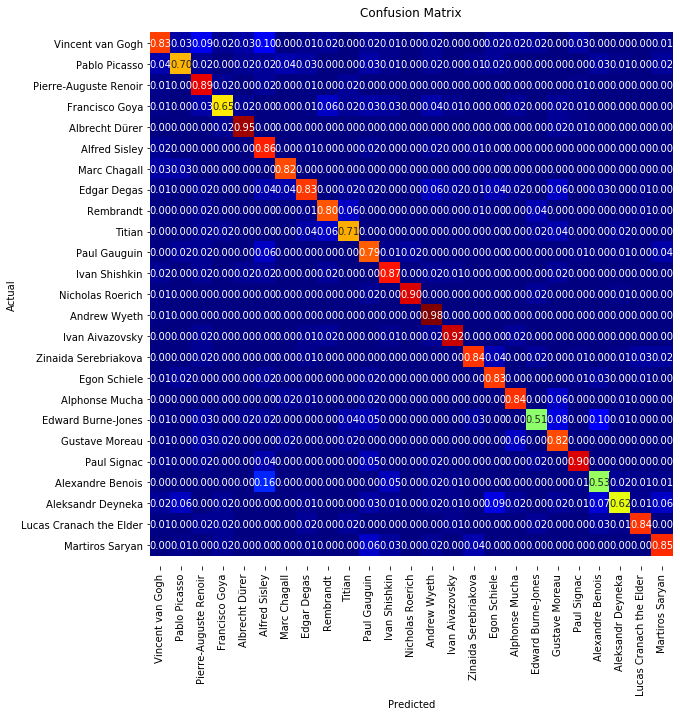

Classification Report:
                         precision    recall  f1-score   support

       Vincent van Gogh       0.79      0.83      0.81       174
          Pablo Picasso       0.79      0.70      0.75        88
  Pierre-Auguste Renoir       0.72      0.89      0.80        64
         Francisco Goya       0.82      0.65      0.73        57
         Albrecht Dürer       0.91      0.95      0.93        64
          Alfred Sisley       0.63      0.86      0.73        50
           Marc Chagall       0.87      0.82      0.84        49
            Edgar Degas       0.81      0.83      0.82       139
              Rembrandt       0.82      0.80      0.81        51
                 Titian       0.79      0.71      0.75        52
           Paul Gauguin       0.69      0.79      0.74        63
          Ivan Shishkin       0.84      0.87      0.86        79
       Nicholas Roerich       0.97      0.90      0.94        41
           Andrew Wyeth       0.79      0.98      0.87        53
 

In [36]:
showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

## **Accuracy vs Epochs**

Text(0, 0.5, 'accuracy')

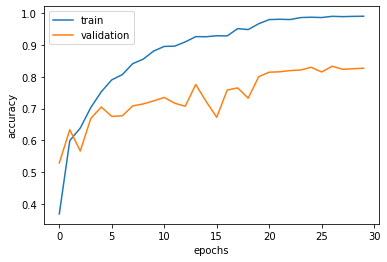

In [43]:
import matplotlib.pyplot as plt

plt.plot(history1.history['acc'], label='train')
plt.plot(history1.history['val_acc'], label='validation')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')